In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

import py_scripts.db_fcns as db
import py_scripts.data_fcns as fcns
import py_scripts.plot_fcns as pf

Ei välitetä datan keruusta, vaan napataan data DB:stä.

In [2]:
alkuasema = "JÄS"
loppuasema = "OV"
# dates = pd.date_range("2023-01-01", periods=59, freq="1D")
dates = pd.date_range("2019-01-01", "2023-05-31", freq="1D")

In [3]:
#timetables = pd.DataFrame()
#for date in dates:
#    new_timetables = fcns.get_train_timetables(str(date.date()))
#    if new_timetables is None:
#        continue
#    timetables = pd.concat([timetables, new_timetables])

## Data haltuun

In [4]:
df = db.get_df_from_db("checkpoint_data", from_extra=True)
checkpoints = df["dist_from_speed"].unique()

df1 = db.get_df_from_db("clean_jamsa_orivesi", from_extra=True)
# df1 = None

if df1 is None:
    df1 = db.get_df_from_db("jamsa_orivesi", from_extra=True)
    
    # poistetaan junat, joilla ei ole sijanti-/nopeustietoja korkeintaan 30 sekunnin välein
    max_time_difference = 30
    
    cleaned_df = pd.DataFrame()
    for train_num, date in df1.groupby(["trainNumber", "departureDate"]).count().index:
        t_df = fcns.get_locations_for_train(train_num, date, df1).copy()
        max_time_jump = t_df["duration"].diff(1).max()
        if max_time_jump <= max_time_difference:
            cleaned_df = pd.concat([cleaned_df, t_df])

    df1 = cleaned_df.reset_index(drop=True)
    
    distances = fcns.get_distances_from_df(df1)
    
    # poistetaan junat, joiden kulkema matka poikkeaa liikaa mediaanista
    min_dist = distances["dist_from_speed"].median() - 4 * (distances["dist_from_speed"].median() - distances["dist_from_speed"].quantile(0.02))
    max_dist = distances["dist_from_speed"].median() + 4 * (distances["dist_from_speed"].quantile(0.98) - distances["dist_from_speed"].median())
    outliers = distances[(distances["dist_from_speed"] < min_dist) | (distances["dist_from_speed"] > max_dist)].set_index(["trainNumber", "departureDate"]).index
    
    for train_num, date in outliers:
        o = fcns.get_locations_for_train(train_num, date, df1)
        i1 = o.index.min()
        i2 = o.index.max() + 1
        df1.drop(range(i1, i2), inplace=True)
    
    df1.reset_index(drop=True, inplace=True)


In [5]:
# tarviiko tallentaa?
db.save_df_to_db(df1, "clean_jamsa_orivesi", to_extra=True)

Table clean_jamsa_orivesi already exists


In [6]:
distances = fcns.get_distances_from_df(df1)
distances["duration"] = fcns.get_durations_from_df(df1).to_numpy()

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814222 entries, 0 to 814221
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   trainNumber         814222 non-null  int64              
 1   departureDate       814222 non-null  object             
 2   timestamp           814222 non-null  datetime64[ns, UTC]
 3   speed               814222 non-null  int64              
 4   duration            814222 non-null  float64            
 5   latitude            814222 non-null  float64            
 6   longitude           814222 non-null  float64            
 7   acceleration        814222 non-null  float64            
 8   change_of_location  814222 non-null  float64            
 9   dist_from_coords    814222 non-null  float64            
 10  dist_from_speed     814222 non-null  float64            
 11  stops_from_speed    814222 non-null  int64              
 12  station         

In [8]:
# df1.head()

In [9]:
# distances.head(3)

In [10]:
distances.set_index(["departureDate", "trainNumber"], inplace=True)
# distances.head(3)

In [11]:
distances.describe()

,dist_from_speed,duration
count,5320.000000,5320.000000
mean,55877.036106,2017.901316
std,116.587095,194.443653
min,54524.861111,1573.000000
25%,55851.111111,1935.000000
50%,55888.333333,1976.000000
75%,55921.111111,2041.000000
max,56552.500000,6646.000000


#### Paras arvio välin Jämsä-Orivesi pituudelle on kuljettujen matkojen mediaani (keskiarvokin kelpaisi)

In [12]:
best_dist = np.round(distances["dist_from_speed"].median(), -2)
best_dist

55900.0

In [13]:
# print(f"Havaintoja aikavälillä  {df1['timestamp'].min().date()} - {df1['timestamp'].max().date()}")

## Skaalataan etäisyydet samoiksi, lisätään checkpointit ja kiihtyvyydelle arvot checkpointeissa

In [14]:
do_more = False
if df is None or checkpoints is None:
    df, checkpoints = fcns.get_essential_df(df1, best_dist)
    do_more = True

In [15]:
# df.info()

In [16]:
# df.head()

## Keskitytään kiihtyvyyteen checkpointeissa

In [17]:
if do_more:
    df = df[df["dist_from_speed"].isin(checkpoints)]
    df.drop_duplicates(["departureDate", "trainNumber", "dist_from_speed"], inplace=True)
    df.reset_index(drop=True, inplace=True)

    df["acceleration+"] = df["acceleration"].apply(lambda a: max(a, 0))
    df["acceleration_abs"] = df["acceleration"].apply(abs)

In [18]:
db.save_df_to_db(df, "checkpoint_data", to_extra=True)

Table checkpoint_data already exists


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2979200 entries, 0 to 2979199
Data columns (total 6 columns):
 #   Column            Dtype  
---  ------            -----  
 0   trainNumber       int64  
 1   departureDate     object 
 2   dist_from_speed   float64
 3   acceleration      float64
 4   acceleration+     float64
 5   acceleration_abs  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 136.4+ MB


### Muunnetaan dataframe klusterointiin sopivaan muotoon

In [20]:
train_df = fcns.get_cluster_df(df)
train_df.insert(0, "abs_sum", np.abs(train_df.loc[:, checkpoints]).sum(axis=1))

In [21]:
train_df.iloc[:5, :10]

dist_from_speed              abs_sum  0.0     100.0     200.0     300.0  \
departureDate trainNumber                                                 
2018-01-01    86           40.875000  0.0  0.500000  0.388889  0.388889   
              146          52.171296  0.0  0.333333  0.314815  0.314815   
2018-01-02    140          28.535737  0.0  0.364583  0.243056  0.243056   
              142          30.041667  0.0  0.296296  0.296296  0.370370   
              144          28.243056  0.0  0.500000  0.329861  0.329861   

dist_from_speed               400.0     500.0     600.0     700.0     800.0  
departureDate trainNumber                                                    
2018-01-01    86           0.370370  0.370370  0.370370  0.074074  0.074074  
              146          0.314815  0.314815  0.314815  0.347222  0.347222  
2018-01-02    140          0.296296  0.296296  0.260417  0.260417  0.260417  
              142          0.370370  0.259259  0.259259  0.259259  0.069444  
              144          0.407407  0.407407  0.407407  0.018519  0.018519

In [22]:
# ongelmia?
# train_df[train_df[0.0] != 0].iloc[:, :5]

### Etsitään suurta vaihtelua (ja sitten ei tehdä löydösten perusteella mitään...)

In [23]:
descr = train_df.loc[:, checkpoints].describe().T.reset_index()
descr["75%-25%"] = descr["75%"] - descr["25%"]

In [24]:
descr.head()

,dist_from_speed,count,mean,std,min,25%,50%,75%,max,75%-25%
0,0.0,5320.0,-0.001005,0.045321,-2.760417,0.000000,0.000000,0.000000,0.000000,0.000000
1,100.0,5320.0,0.384028,0.125326,-0.138889,0.312500,0.370370,0.444444,2.259259,0.131944
2,200.0,5320.0,0.385728,0.126865,-0.814815,0.314815,0.381944,0.444444,2.259259,0.129630
3,300.0,5320.0,0.373223,0.115984,-0.296296,0.306652,0.370370,0.444444,1.197917,0.137792
4,400.0,5320.0,0.324865,0.109645,-0.314815,0.259259,0.329861,0.388889,0.981481,0.129630


In [25]:
# np.where(checkpoints == features[0])

In [26]:
# features

In [27]:
num_of_features = 20
lower_bound = descr.sort_values("75%-25%", ascending=False).iloc[num_of_features - 1, -1]
features = descr[descr["75%-25%"] >= lower_bound].index
descr.sort_values("75%-25%", ascending=False).head(num_of_features)

,dist_from_speed,count,mean,std,min,25%,50%,75%,max,75%-25%
559,55900.0,5320.0,-0.221006,0.170447,-2.037037,-0.329861,-0.185185,-0.075758,-0.013889,0.254104
558,55800.0,5320.0,-0.372343,0.160845,-2.444444,-0.462963,-0.361111,-0.260417,0.185185,0.202546
15,1500.0,5320.0,0.136694,0.126022,-0.574074,0.037037,0.111111,0.222222,1.388889,0.185185
525,52500.0,5320.0,-0.139405,0.114817,-0.685185,-0.222222,-0.129630,-0.046296,0.520833,0.175926
526,52600.0,5320.0,-0.139777,0.116747,-0.972222,-0.222222,-0.129630,-0.046296,0.520833,0.175926
14,1400.0,5320.0,0.150541,0.122477,-0.574074,0.055556,0.129630,0.231481,0.729167,0.175926
557,55700.0,5320.0,-0.333444,0.151261,-3.000000,-0.416667,-0.314815,-0.240741,0.399306,0.175926
6,600.0,5320.0,0.194553,0.114535,-1.111111,0.111111,0.203704,0.277778,0.833333,0.166667
7,700.0,5320.0,0.147513,0.108920,-0.462963,0.055556,0.131579,0.222222,0.868056,0.166667
16,1600.0,5320.0,0.086712,0.123783,-0.574074,0.000000,0.046296,0.166667,0.722222,0.166667


In [28]:
# features = checkpoints[features]
features

Int64Index([  6,   7,  13,  14,  15,  16,  21,  22,  35,  36,  37, 524, 525,
            526, 527, 554, 556, 557, 558, 559],
           dtype='int64')

## KMeans-klusterointi

Kun on siistimpää dataa, voi käyttää vähemmän klustereita.

In [29]:
rng = 4097

In [30]:
num_of_clusters = 5

km, cluster_ids = fcns.run_kmeans(train_df.loc[:, checkpoints], num_of_clusters, rng)

In [31]:
km.n_iter_

40

In [32]:
if "cluster_id" in train_df.columns:
    train_df.drop("cluster_id", axis=1, inplace=True)
train_df.insert(0, "cluster_id", cluster_ids)

In [33]:
clustering_results = df.groupby(["departureDate", "trainNumber"]).mean()
clustering_results["cluster_id"] = km.predict(train_df.loc[:, checkpoints])
cluster_df = fcns.get_clusters(clustering_results)
cluster_df

,count,min_mean_abs_accel,max_mean_abs_accel,mean_mean_abs_accel
cluster_id,,,,
0,1664,0.038891,0.195115,0.069442
2,1577,0.048679,0.223154,0.073453
1,1490,0.018651,0.159276,0.063231
4,388,0.055220,0.176010,0.087531
3,201,0.044517,0.113635,0.079094


In [34]:
cluster_df["mean_mean_abs_accel"].sort_values() * len(checkpoints)

cluster_id
1    35.409494
0    38.887527
2    41.133713
3    44.292659
4    49.017089
Name: mean_mean_abs_accel, dtype: float64

In [76]:
train_df[train_df["cluster_id"] == 4]["cluster_id"]

departureDate  trainNumber
2018-01-01     146            4
2018-01-03     140            4
2018-01-10     86             4
               148            4
2018-01-16     148            4
                             ..
2023-06-08     142            4
2023-06-09     88             4
               142            4
               146            4
2023-06-14     88             4
Name: cluster_id, Length: 388, dtype: int32

### Ajankohdan merkitys

Tarkastellaan junavuorojen kuukausijakaumaa klustereittain. Onko jossain klusterissa paljon talvella kulkevia junia, tai kenties kesävuoroja.

In [35]:
kokeilu = clustering_results.reset_index()
kokeilu["departureDate"] = pd.to_datetime(kokeilu["departureDate"])
kokeilu.drop("dist_from_speed", axis=1, inplace=True)
kokeilu["month"] = kokeilu["departureDate"].apply(lambda t: t.month)

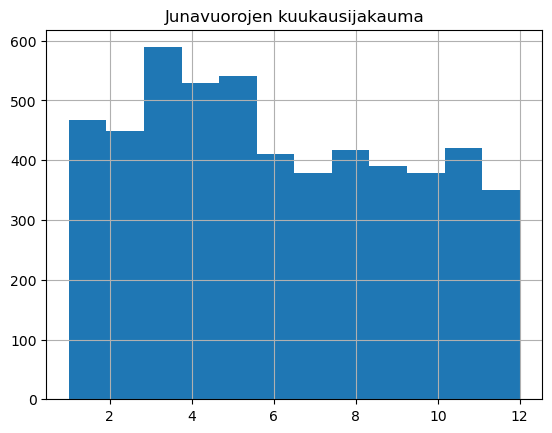

In [36]:
plt.hist(kokeilu["month"], bins=12)
plt.title("Junavuorojen kuukausijakauma")
plt.grid()
plt.show()

Kokonaisuudessaan (datassa olevia) junavuoroja on eniten maalis-toukokuussa. Klusteri 0 näyttää painottuvan talveen, klusteri 2 kevääseen ja klusteri 1 kevääseen ja syksyyn.

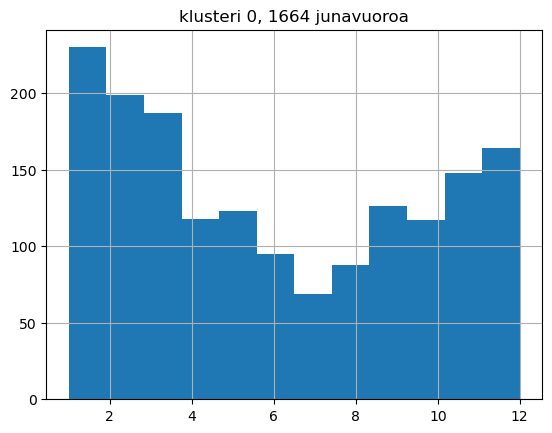

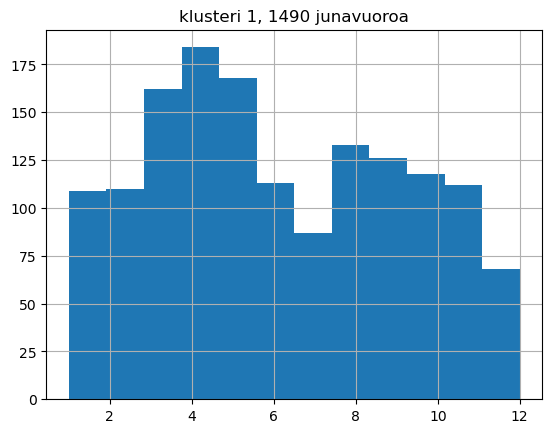

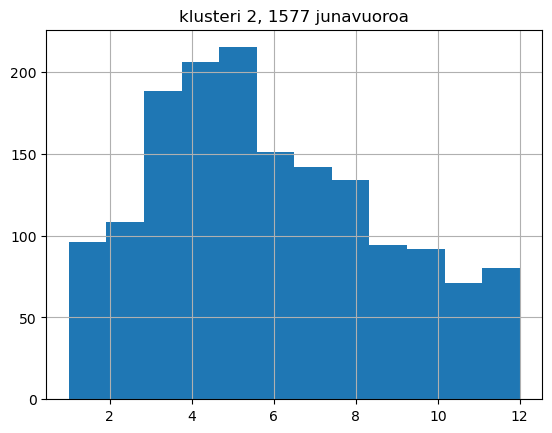

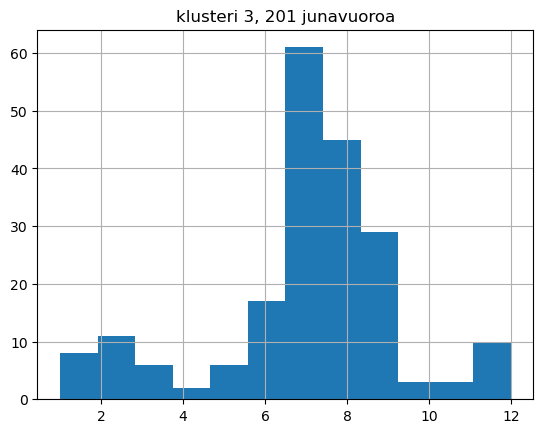

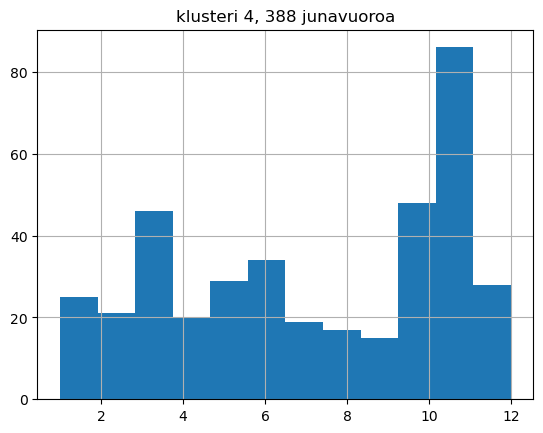

In [77]:
for i in range(kokeilu["cluster_id"].max() + 1):
    kok_df = kokeilu[kokeilu["cluster_id"] == i]
    # if len(kok_df) > 0.1 * len(kokeilu):
    plt.hist(kok_df["month"], bins=12)
    plt.title(f"klusteri {i}, {kokeilu['cluster_id'].value_counts().loc[i]} junavuoroa")
    plt.grid()
    plt.show()

## Testataan klusteroinnin ennustettavuutta

Oppivatko koneoppimismallit kategorisoimaan junavuorot klustereihin?

In [38]:
c_res = clustering_results.loc[:, ["cluster_id", "acceleration"]]
# c_df = clustering_df

Yhdistetään pienemmät klusterit yhteen.

In [39]:
default_lower_bound = max(30, 0.1 * len(train_df))
c_res["cluster_id"] = c_res["cluster_id"].apply(lambda n: fcns.replacement_fcn(n, cluster_df["count"], default_lower_bound))

In [40]:
c_res["cluster_id"].value_counts()

 0    1664
 1    1577
 2    1490
-1     589
Name: cluster_id, dtype: int64

#### k-nearest neighbors

In [41]:
knn = fcns.test_clusters_with_knn(train_df.loc[:, checkpoints], c_res["cluster_id"].to_numpy(), test_size=0.4)

Accuracy: 0.8486842105263158

              precision    recall  f1-score   support

          -1       0.99      0.92      0.95       108
           0       0.83      0.86      0.85       352
           1       0.87      0.80      0.83       295
           2       0.81      0.86      0.83       309

    accuracy                           0.85      1064
   macro avg       0.87      0.86      0.87      1064
weighted avg       0.85      0.85      0.85      1064



#### random forest

In [42]:
rfc = fcns.test_clusters_with_rfc(train_df.loc[:, checkpoints], c_res["cluster_id"].to_numpy(), test_size=0.4)

Accuracy: 0.8580827067669173

              precision    recall  f1-score   support

          -1       0.95      0.92      0.93       108
           0       0.90      0.85      0.87       343
           1       0.82      0.89      0.85       331
           2       0.83      0.80      0.82       282

    accuracy                           0.86      1064
   macro avg       0.87      0.87      0.87      1064
weighted avg       0.86      0.86      0.86      1064



In [43]:
importances = [{"checkpoint": checkpoints[i], "importance": importance} for i, importance in enumerate(rfc.feature_importances_)]
importances = pd.DataFrame(importances)
importances.sort_values("importance", ascending=False).head(20)

,checkpoint,importance
35,3500.0,0.018640
37,3700.0,0.018121
36,3600.0,0.017335
366,36600.0,0.015282
38,3800.0,0.013702
367,36700.0,0.013688
322,32200.0,0.013237
186,18600.0,0.012746
39,3900.0,0.011643
34,3400.0,0.011361


## Piirrellään kuvaajia

In [44]:
def bright_spot(i, num):
    if i == num:
        return 0.9
    return 0.3

#### Suurimpien klustereiden keskipisteet

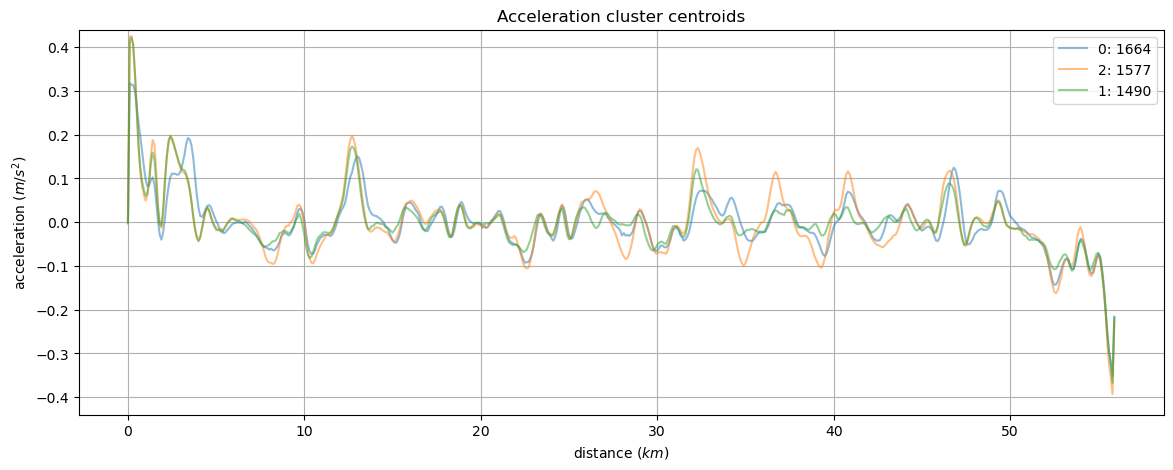

In [45]:
pf.draw_kmeans_centroids(km, checkpoints, train_df["cluster_id"], 3, 0.44)

Samalla voi muistella, että klusterissa 1 on keskimäärin pienempiä kiihtyvyyksiä ja klusterissa 2 keskimäärin suurempia kiihtyvyyksiä kuin klusterissa 0.

In [46]:
cluster_df["mean_mean_abs_accel"].sort_values() * len(checkpoints)

cluster_id
1    35.409494
0    38.887527
2    41.133713
3    44.292659
4    49.017089
Name: mean_mean_abs_accel, dtype: float64

In [47]:
#fig, ax = plt.subplots(figsize=(14, 5))
#ax.plot(checkpoints / 1000, km.cluster_centers_[0, :])

#ax.set_ylabel("acceleration ($m/s^2$)")
#ax.set_xlabel("distance ($km$)")
#ax.set_ylim(-0.5, 0.5)
#ax.grid()
#plt.show()

#### Miten klustereiden keskipisteet eroavat random forestin mielestä tärkeissä kohdissa?

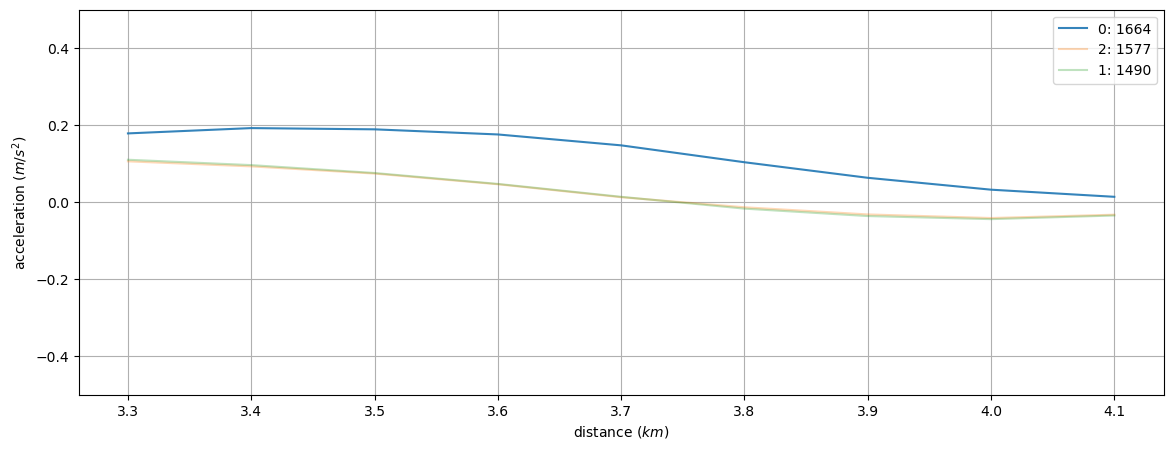

In [48]:
n = 3
start_i = 33
end_i = 42

fig, ax = plt.subplots(figsize=(14, 5))
for i in cluster_df.index[:n]:

    ax.plot(checkpoints[start_i:end_i] / 1000, km.cluster_centers_[i, start_i:end_i], alpha=bright_spot(i, 0), label=f"{i}: {cluster_df.loc[i, 'count']}")

ax.set_ylabel("acceleration ($m/s^2$)")
ax.set_xlabel("distance ($km$)")
ax.set_ylim(-0.5, 0.5)
ax.legend()
ax.grid()
plt.show()

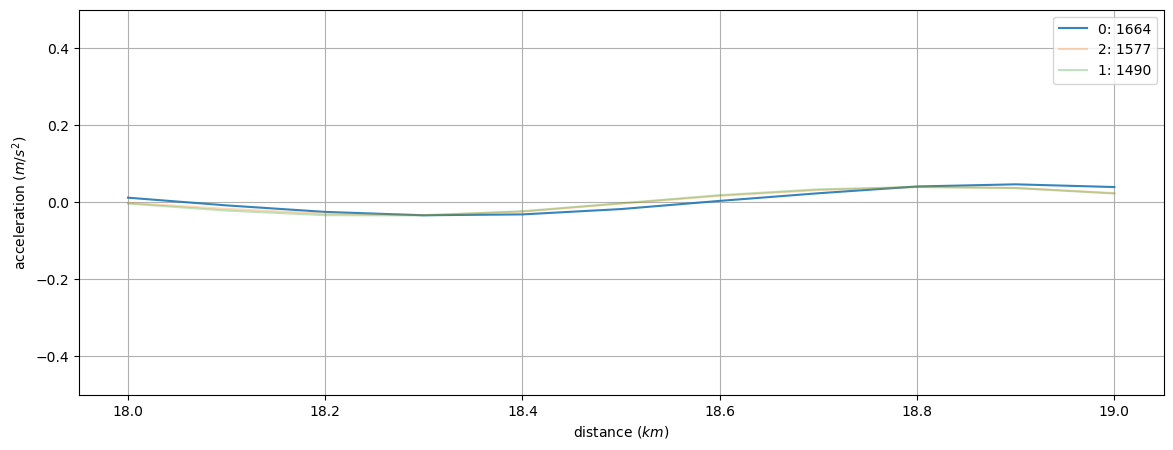

In [49]:
start_i = 180
end_i = 191

fig, ax = plt.subplots(figsize=(14, 5))
for i in cluster_df.index[:n]:

    ax.plot(checkpoints[start_i:end_i] / 1000, km.cluster_centers_[i, start_i:end_i], alpha=bright_spot(i, 0), label=f"{i}: {cluster_df.loc[i, 'count']}")

ax.set_ylabel("acceleration ($m/s^2$)")
ax.set_xlabel("distance ($km$)")
ax.set_ylim(-0.5, 0.5)
ax.legend()
ax.grid()
plt.show()

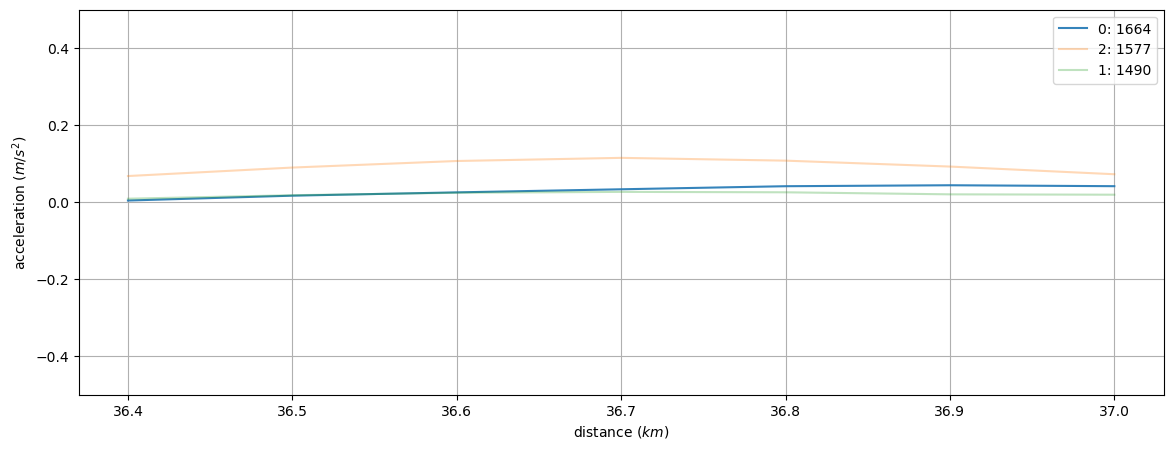

In [50]:
start_i = 364
end_i = 371

fig, ax = plt.subplots(figsize=(14, 5))
for i in cluster_df.index[:n]:

    ax.plot(checkpoints[start_i:end_i] / 1000, km.cluster_centers_[i, start_i:end_i], alpha=bright_spot(i, 0), label=f"{i}: {cluster_df.loc[i, 'count']}")

ax.set_ylabel("acceleration ($m/s^2$)")
ax.set_xlabel("distance ($km$)")
ax.set_ylim(-0.5, 0.5)
ax.legend()
ax.grid()
plt.show()

#### Miltä vähiten kiihdytelleet junat näyttävät?

In [51]:
# kaikki klusterissa 0
train_df.loc[:, ["cluster_id", "abs_sum"]].sort_values("abs_sum").head(15)

,dist_from_speed,cluster_id,abs_sum
departureDate,trainNumber,,
2022-12-05,144,1,10.444444
2020-07-29,140,1,14.170139
2022-09-22,80,1,15.045287
2022-09-17,146,1,15.567302
2022-10-04,80,1,16.085796
2021-08-22,86,1,18.392361
2022-08-27,148,1,18.452877
2021-10-24,86,1,18.828704
2021-03-27,140,1,19.761574


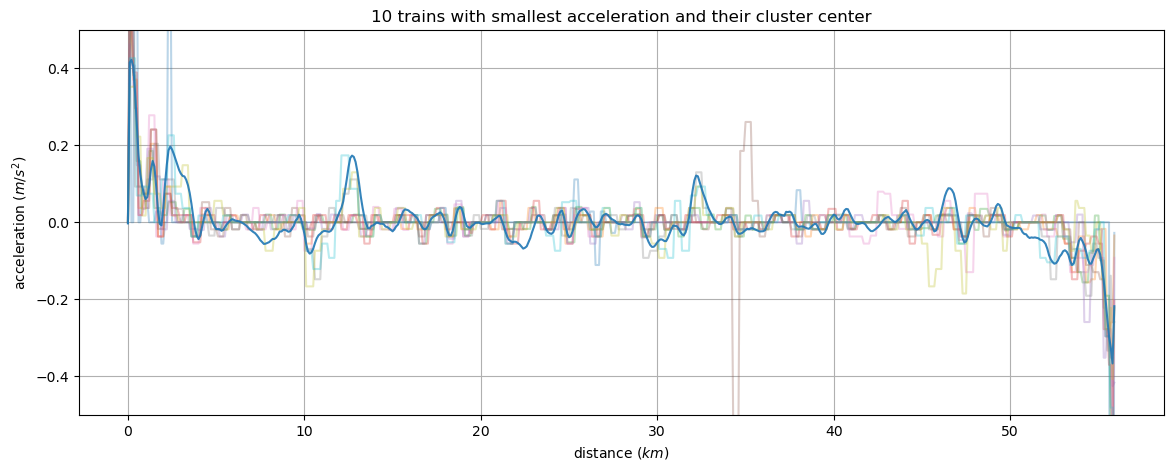

In [52]:
num_of_trains = 10

fig, ax = plt.subplots(figsize=(14, 5))
for date_and_num in train_df.loc[:, ["cluster_id", "abs_sum"]].sort_values("abs_sum").index[:num_of_trains]:
    ax.plot(checkpoints / 1000, train_df.loc[date_and_num, checkpoints], label=date_and_num, alpha=0.3)

ax.plot(checkpoints / 1000, km.cluster_centers_[1, :], alpha=0.9)

ax.set_title(f"{num_of_trains} trains with smallest acceleration and their cluster center")
ax.set_ylabel("acceleration ($m/s^2$)")
ax.set_xlabel("distance ($km$)")
ax.set_ylim(-0.5, 0.5)
# ax.legend()
ax.grid()
plt.show()

#### Entäs checkpointit, joissa kiihtyvyyksissä on suurinta hajontaa?

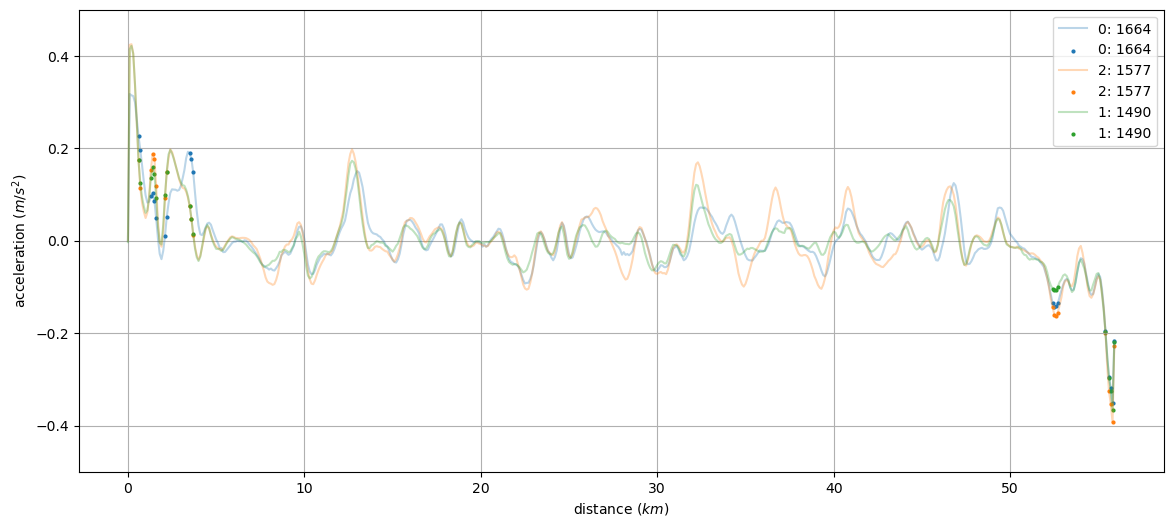

In [53]:
fig, ax = plt.subplots(figsize=(14, 6))
for i in cluster_df.index[:n]:
    ax.plot(checkpoints / 1000, km.cluster_centers_[i, :], alpha=0.3, label=f"{i}: {cluster_df.loc[i, 'count']}")
    ax.scatter(checkpoints[features] / 1000, km.cluster_centers_[i, features], s=4, label=f"{i}: {cluster_df.loc[i, 'count']}")

ax.set_ylabel("acceleration ($m/s^2$)")
ax.set_xlabel("distance ($km$)")
ax.set_ylim(-0.5, 0.5)
ax.legend()
ax.grid()
plt.show()

In [54]:
cluster_df

,count,min_mean_abs_accel,max_mean_abs_accel,mean_mean_abs_accel
cluster_id,,,,
0,1664,0.038891,0.195115,0.069442
2,1577,0.048679,0.223154,0.073453
1,1490,0.018651,0.159276,0.063231
4,388,0.055220,0.176010,0.087531
3,201,0.044517,0.113635,0.079094


In [55]:
for i in range(num_of_clusters):
    print(f"{i}: \t{str(np.round(np.sum(km.cluster_centers_[i, :]), 3)).rjust(7)}")

0: 	 -0.177
1: 	 -0.196
2: 	 -0.216
3: 	 -0.169
4: 	 -0.191


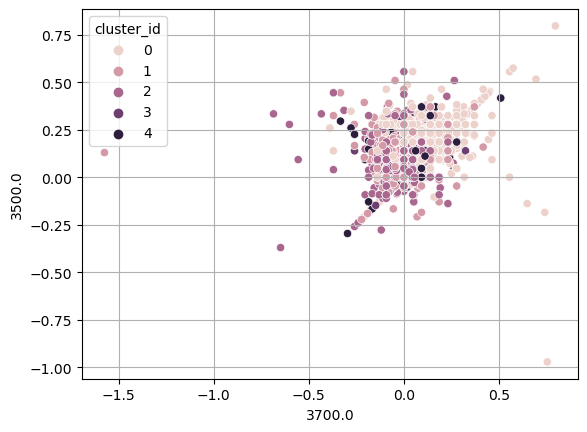

In [78]:
sns.scatterplot(x=3700.0, y=3500.0, hue="cluster_id", data=train_df)
plt.grid()
plt.show()

## PCA-kokeilua

In [57]:
pca = PCA(n_components=2)
transformed_accel = pca.fit_transform(train_df.loc[:, checkpoints])

In [58]:
transformed_accel.shape

(5320, 2)

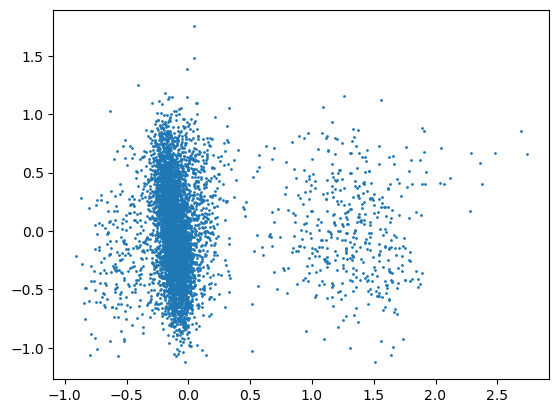

In [59]:
plt.scatter(transformed_accel[:, 0], transformed_accel[:, 1], s=1)
plt.show()

In [60]:
comp_df = pd.DataFrame(transformed_accel, columns=["pca1", "pca2"])
comp_df["cluster_id"] = train_df["cluster_id"].to_numpy()
# comp_and_cluster_df = pd.concat([train_df["cluster_id"], comp_df], axis=1)

In [61]:
comp_df.head()

,pca1,pca2,cluster_id
0,-0.012888,0.108303,1
1,1.723670,0.295001,4
2,-0.380756,0.042439,1
3,-0.129470,0.080007,1
4,-0.018327,-0.318913,2


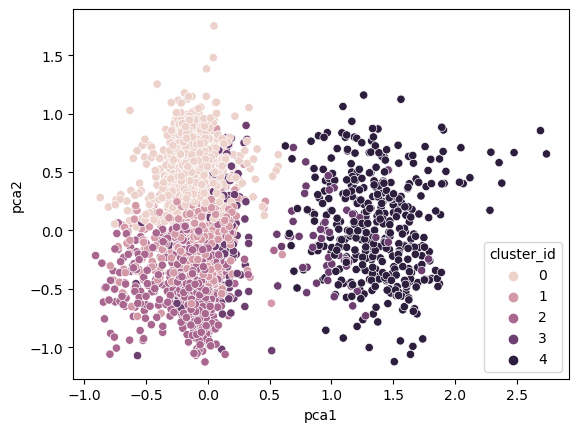

In [62]:
sns.scatterplot(x="pca1", y="pca2", hue="cluster_id", data=comp_df)
plt.show()

In [63]:
pca.components_

array([[-0.00075775,  0.00663801,  0.00557729, ..., -0.01777563,
        -0.0216886 , -0.0036096 ],
       [ 0.00033282, -0.13801094, -0.14810299, ...,  0.03903048,
         0.04137051,  0.01262413]])

In [64]:
pca.explained_variance_

array([0.18770803, 0.17026079])

#### uudestaan

In [65]:
pca = PCA(n_components=20)
transformed_accel = pca.fit_transform(train_df.loc[:, checkpoints])

In [66]:
pca_names = [f"pca{i+1}" for i in range(transformed_accel.shape[1])]
comp_df = pd.DataFrame(transformed_accel, columns=pca_names)
comp_df["cluster_id"] = train_df["cluster_id"].to_numpy()

In [67]:
comp_df.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,...,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,cluster_id
0,-0.012927,0.108237,0.005926,0.155056,0.388663,-0.654952,0.287448,-0.835004,-0.178221,-0.126689,...,-0.560965,-0.354589,0.142573,0.146986,-0.239391,-0.400900,0.083692,0.068628,0.138683,1
1,1.723660,0.294980,-0.027293,-0.199224,0.101433,-0.657140,0.312378,0.029005,0.448329,-0.328250,...,-0.150406,-0.099570,0.131093,-0.394604,-0.496086,0.086108,-0.165223,-0.229924,0.420539,4
2,-0.380824,0.042338,-0.190027,0.549671,0.199289,0.061159,-0.112397,-0.164952,0.201302,-0.070181,...,-0.288403,0.324317,0.126974,-0.380043,0.164682,-0.067724,-0.066501,0.085699,0.041733,1
3,-0.129454,0.080008,-0.133933,0.062512,0.164191,-0.184647,-0.006197,0.020762,0.056505,-0.031289,...,0.086353,0.400653,0.061580,0.081301,-0.275416,-0.109460,0.063606,0.039675,-0.048705,1
4,-0.018314,-0.318885,-0.120626,-0.046793,0.197437,-0.202928,-0.027594,-0.095190,0.027750,0.154447,...,0.140469,-0.023258,-0.247779,0.011628,0.047937,-0.036942,0.045455,-0.167829,-0.143255,2


In [74]:
for i, var in enumerate(pca.explained_variance_):
    print(f"{i}: \t{var:.3f} \t\t{100 * pca.explained_variance_ratio_[i]:.3f} % \t{100 * pca.explained_variance_ratio_.cumsum()[i]:.3f} %")

0: 	0.188 		4.281 % 	4.281 %
1: 	0.170 		3.883 % 	8.164 %
2: 	0.122 		2.794 % 	10.958 %
3: 	0.110 		2.508 % 	13.465 %
4: 	0.091 		2.070 % 	15.535 %
5: 	0.083 		1.899 % 	17.434 %
6: 	0.077 		1.763 % 	19.197 %
7: 	0.066 		1.506 % 	20.703 %
8: 	0.064 		1.458 % 	22.160 %
9: 	0.059 		1.343 % 	23.504 %
10: 	0.058 		1.322 % 	24.826 %
11: 	0.056 		1.274 % 	26.100 %
12: 	0.050 		1.137 % 	27.237 %
13: 	0.047 		1.067 % 	28.304 %
14: 	0.046 		1.046 % 	29.350 %
15: 	0.045 		1.015 % 	30.365 %
16: 	0.043 		0.990 % 	31.355 %
17: 	0.042 		0.948 % 	32.302 %
18: 	0.040 		0.923 % 	33.225 %
19: 	0.037 		0.855 % 	34.080 %


In [69]:
from itertools import combinations

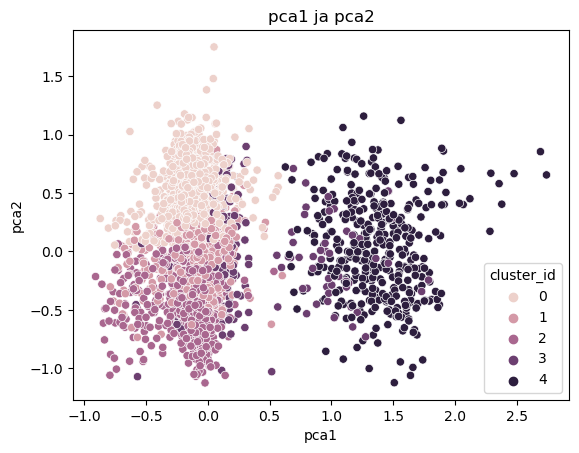

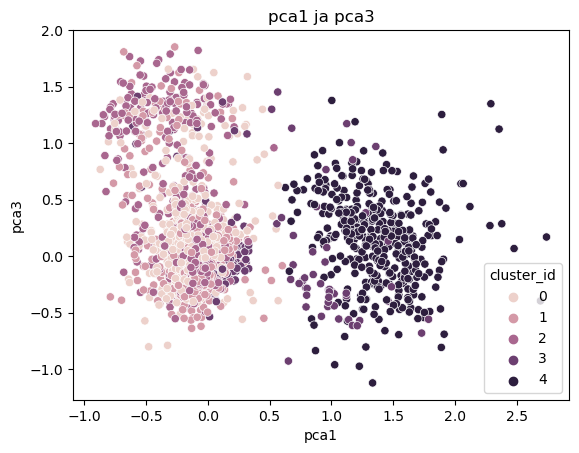

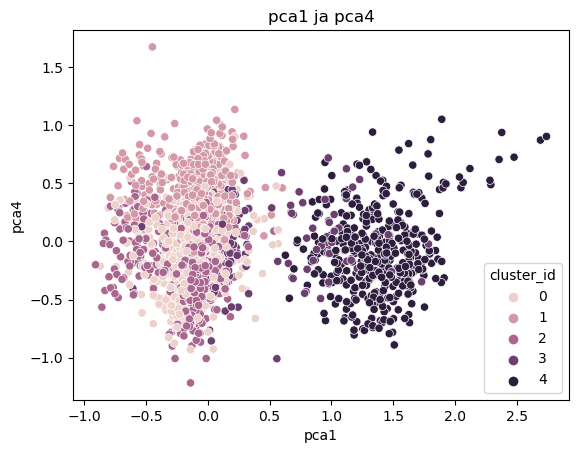

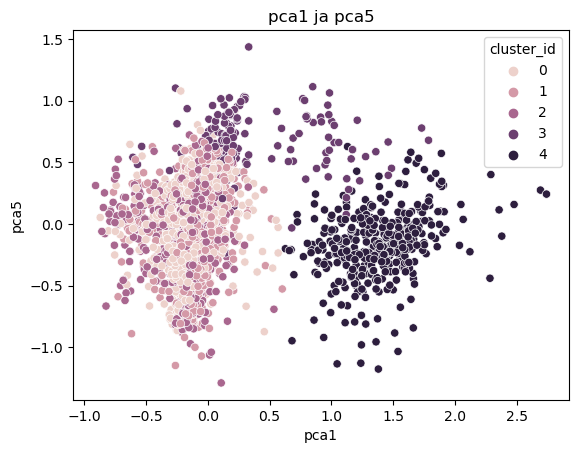

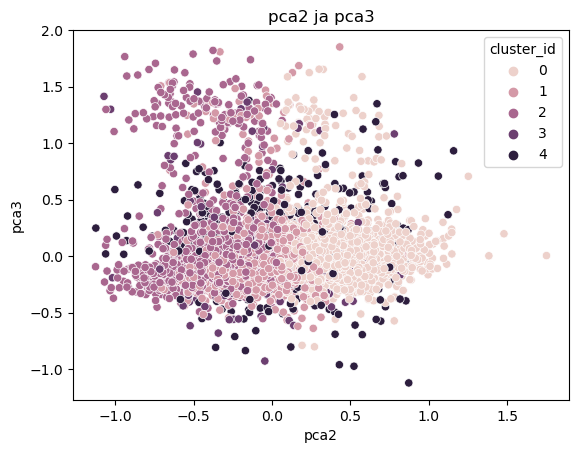

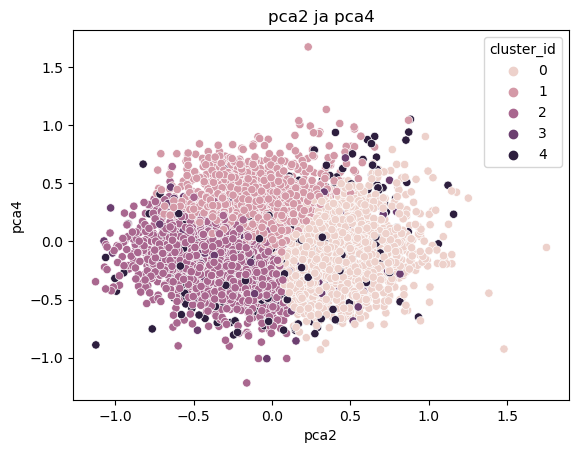

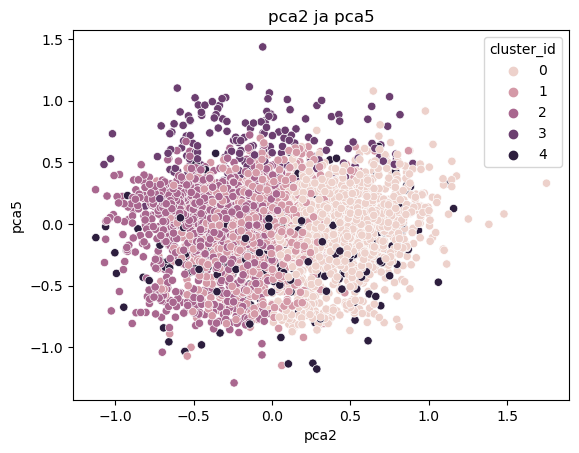

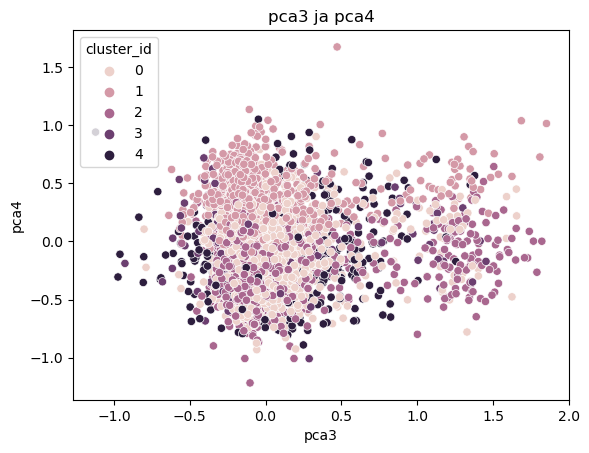

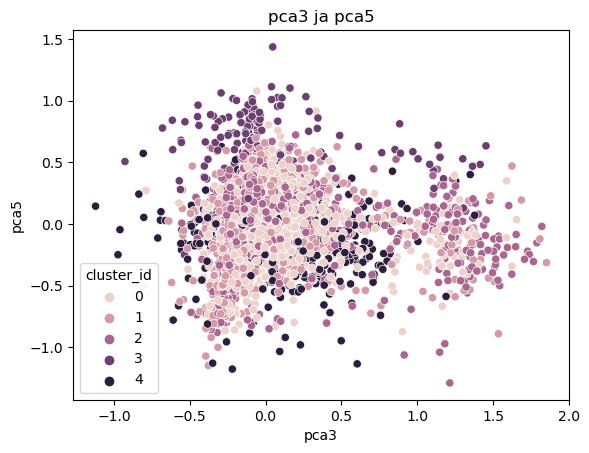

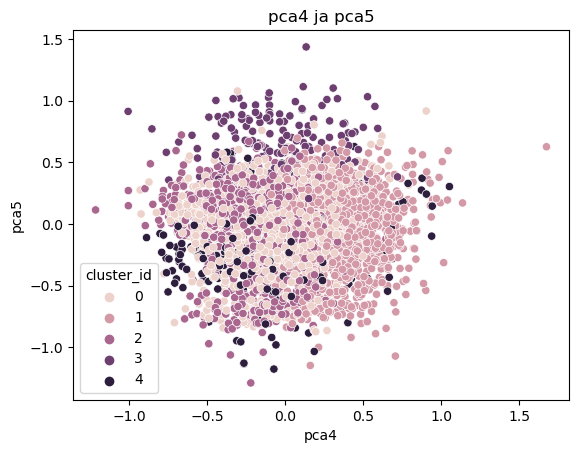

In [70]:
for col1, col2 in combinations(pca_names[:5], 2):
    sns.scatterplot(x=col1, y=col2, hue="cluster_id", data=comp_df)
    plt.title(f"{col1} ja {col2}")
    plt.show()